# KNN Functions:

In [1]:
from typing import List
from collections import Counter

def raw_majority_vote(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner

assert raw_majority_vote(['a', 'b', 'c', 'b']) == 'b'


def majority_vote(labels: List[str]) -> str:
    """Assumes that labels are ordered from nearest to farthest."""
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count
                    for count in vote_counts.values()
                    if count == winner_count])
    if num_winners == 1:
        return winner # unique winner, so return it
    else:
        return majority_vote(labels[:-1]) # try again without the farthest
    # Tie, so look at first 4, then 'b'
    assert majority_vote(['a', 'b', 'c', 'b', 'a']) == 'b'


from typing import NamedTuple
from scratch.linear_algebra import Vector, distance

class LabeledPoint(NamedTuple):
    point: Vector
    label: str
def knn_classify(k: int,
    labeled_points: List[LabeledPoint],
    new_point: Vector) -> str:
    # Order the labeled points from nearest to farthest.
    by_distance = sorted(labeled_points,
                key=lambda lp: distance(lp.point, new_point))
    # Find the labels for the k closest
    k_nearest_labels = [lp.label for lp in by_distance[:k]]
    
    # and let them vote.
    return majority_vote(k_nearest_labels)

# Get Data

In [2]:
from collections import Counter, defaultdict
from typing import Dict, List
import csv

with open('fruit_data_with_colors.txt') as f:
    tab_reader = csv.reader(f, delimiter='\t')
    next(tab_reader, None)  # skip the headers 
    fruit_data = [LabeledPoint([float(row[3]),
                                 float(row[4]),
                                 float(row[5]),
                                 float(row[6])],
                                row[1]) for row in tab_reader]  # use row[2] for sub-type labels
        
# We'll also group just the points by species/label so we can plot them
points_by_fruit: Dict[str, List[Vector]] = defaultdict(list)
for fruit in fruit_data:
    points_by_fruit[fruit.label].append(fruit.point)

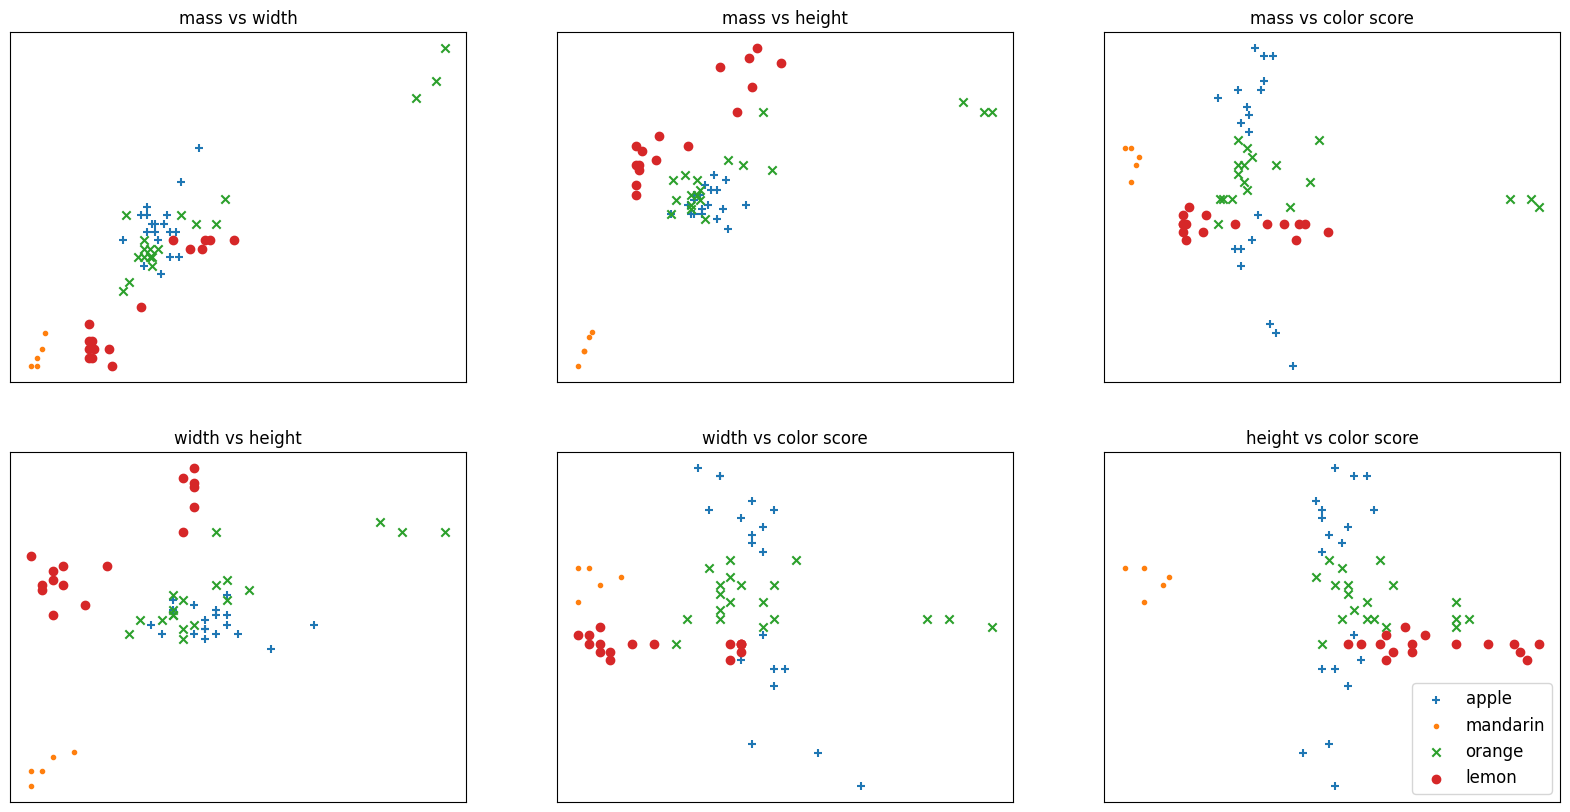

In [3]:
from matplotlib import pyplot as plt

metrics = ['mass', 'width', 'height','color score']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x', 'o'] # we have 4 classes, so 4 markers
# marks = ['+', '.', 'x', 'o', 'v',
#          '^', '>', '<', 'd', 's'] # we have 10 classes, so 10 markers

fig, ax = plt.subplots(2, 3,figsize = (20,10))
for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=12)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])
        for mark, (fruit, points) in zip(marks, points_by_fruit.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=fruit)
            
ax[-1][-1].legend(loc='lower right', prop={'size': 12})
plt.savefig('fruit_scatterplots.png')
plt.show()

In [4]:
from typing import Tuple
import random
from scratch.machine_learning import split_data

#To start with, let’s split the data into a test set and a training set:
#random.seed(12)
fruit_train, fruit_test = split_data(fruit_data, 0.80)
#assert len(fruit_train) == 0.7 * 150
#assert len(fruit_test) == 0.3 * 150

# track how many times we see (predicted, actual)
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

for fruit in fruit_test:
    predicted = knn_classify(3, fruit_train, fruit.point)
    actual = fruit.label
    if predicted == actual:
        num_correct += 1
        
    confusion_matrix[(predicted, actual)] += 1

pct_correct = num_correct / len(fruit_test)
print('percent correct:', pct_correct, '\n')
print(confusion_matrix) 

percent correct: 0.5833333333333334 

defaultdict(<class 'int'>, {('orange', 'orange'): 2, ('lemon', 'lemon'): 4, ('orange', 'lemon'): 2, ('orange', 'apple'): 2, ('apple', 'orange'): 1, ('mandarin', 'mandarin'): 1})


In [5]:
# try several different values for k
for k in [1,2, 3,4, 5,6, 7]:
    num_correct = 0

    for fruit in fruit_data:

        other_fruits = [other_fruit
                        for other_fruit in fruit_data
                        if other_fruit != fruit ]

        predicted = knn_classify(k, other_fruits, fruit.point)

        if predicted == fruit.label:
            num_correct += 1

    print(k, "neighbor[s]:", num_correct, "correct out of", len(fruit_data))

1 neighbor[s]: 39 correct out of 59
2 neighbor[s]: 39 correct out of 59
3 neighbor[s]: 44 correct out of 59
4 neighbor[s]: 44 correct out of 59
5 neighbor[s]: 38 correct out of 59
6 neighbor[s]: 37 correct out of 59
7 neighbor[s]: 33 correct out of 59
